# Setup

## Imports

In [1]:
import numpy as np

##

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models

##

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

##

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

2026-02-18 16:05:07.728283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Config

In [2]:
gpus = tf.config.list_physical_devices("GPU")

for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {gpu}")
    except Exception as e:
        print(e)


Enabled memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Data Preprocessing

## Loading Data

In [3]:
cifar10 = tf.keras.datasets.cifar10.load_data()


In [4]:
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

## Train-Test-Valid Split

In [5]:
(X_train_val,y_train_val), (X_test,y_test) = cifar10

In [6]:
X_train_val = X_train_val.astype("float32") / 255 # as they are 8 bit integer  images
X_test = X_test.astype("float32") / 255 

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.1)

In [8]:
type(X_train)

numpy.ndarray

## Plotting Images Samples

In [9]:
y_train[7777]

array([6], dtype=uint8)

In [10]:
y_train[7777][0]   ## returns the int value not a 0 dimension array

6

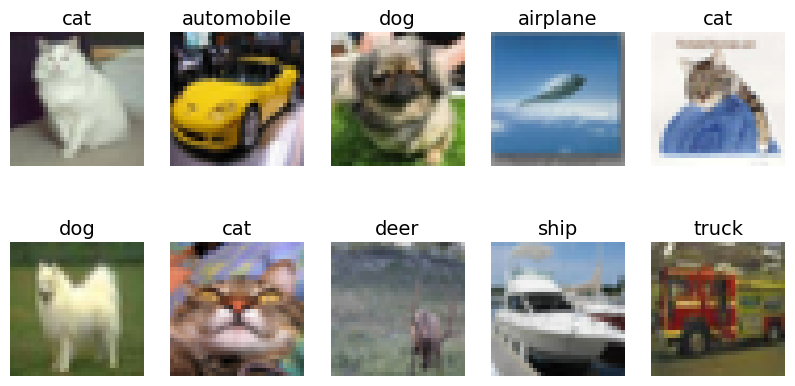

In [11]:
plt.figure(figsize=(10, 5))

for i in range(10):
    k = np.random.choice(len(X_train))
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[k])
    plt.title(class_names[y_train[k][0]])   ## As previously shown
    plt.axis("off")
plt.show()


About to encode y, doing this before the plot makes everything incredibly messy

In [12]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_valid = to_categorical(y_valid, num_classes=10)

you dont need to encode the integer values if you use sparse_categorical_crossentropy instead of categorical_crossentropy.

In [13]:
# X_train = np.expand_dims(X_train, axis=-1)
# X_valid = np.expand_dims(X_valid, axis=-1)
# X_test = np.expand_dims(X_test, axis=-1)

## not necessary as tensors already have the correct number of dimensions for

##  Building an Image Augmentor

In [14]:
idg = ImageDataGenerator(
    # rotation_range=5,        # random rotation up to 15 degrees
    width_shift_range=0.05,    # horizontal shift
    height_shift_range=0.05,   # vertical shift
    horizontal_flip=True,     # randomly flip images
    zoom_range=0.1,           # zoom in/out
    fill_mode="nearest",       # fill missing pixels
    # brightness_range = [0.9, 1.1]
)

idg.fit(X_train)

image_augmentor = idg.flow(
    X_train,
    y_train,
    batch_size=64
)

# Model 1

## Architecture

In [16]:
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),                            # pooling layer
    tf.keras.layers.Flatten(),                              # bridge to the dense layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

I0000 00:00:1771420535.163908  288373 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11006 MB memory:  -> device: 0, name: AMD Radeon RX 6750 XT, pci bus id: 0000:2d:00.0


In [17]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        81,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,826 (323.54 KB)

 Trainable params: 82,826 (323.54 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling

In [18]:
model_1_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [19]:
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=model_1_optimizer,
    metrics=["accuracy"]
    )

In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,                 # metric to monitor             # metric to monitor
    patience=3,                     # stop if no improvement after 3 epochs
    restore_best_weights=True
)

## Fitting

In [21]:
model_1_history = model_1.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping])

Epoch 1/100


2026-02-18 13:15:37.826971: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f02d4007850 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
2026-02-18 13:15:37.826986: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): AMD Radeon RX 6750 XT, AMDGPU ISA version: gfx1030
2026-02-18 13:15:37.842676: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  29/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1056 - loss: 2.6396

I0000 00:00:1771420539.782666  289110 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2258 - loss: 2.1703

2026-02-18 13:15:45.158931: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2259 - loss: 2.1700

2026-02-18 13:15:49.630638: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.3046 - loss: 1.9460 - val_accuracy: 0.4426 - val_loss: 1.6258
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4433 - loss: 1.5847 - val_accuracy: 0.5008 - val_loss: 1.4780
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4962 - loss: 1.4571 - val_accuracy: 0.5300 - val_loss: 1.4006
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5204 - loss: 1.3853 - val_accuracy: 0.5472 - val_loss: 1.3401
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5368 - loss: 1.3391 - val_accuracy: 0.5550 - val_loss: 1.3035
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5513 - loss: 1.3001 - val_accuracy: 0.5702 - val_loss: 1.2750
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5622 - loss: 1.2715 - val_accuracy: 0.5696 - val_loss: 1.2564
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5718 - loss: 1.2464 - val

## Evaluating Model

In [22]:
model_1_accuracy = model_1_history.history["accuracy"]
model_1_accuracy_val = model_1_history.history["val_accuracy"]
model_1_loss = model_1_history.history["loss"]
model_1_loss_val = model_1_history.history["val_loss"]

model_1_epochs = range(1,len(model_1_accuracy)+1)


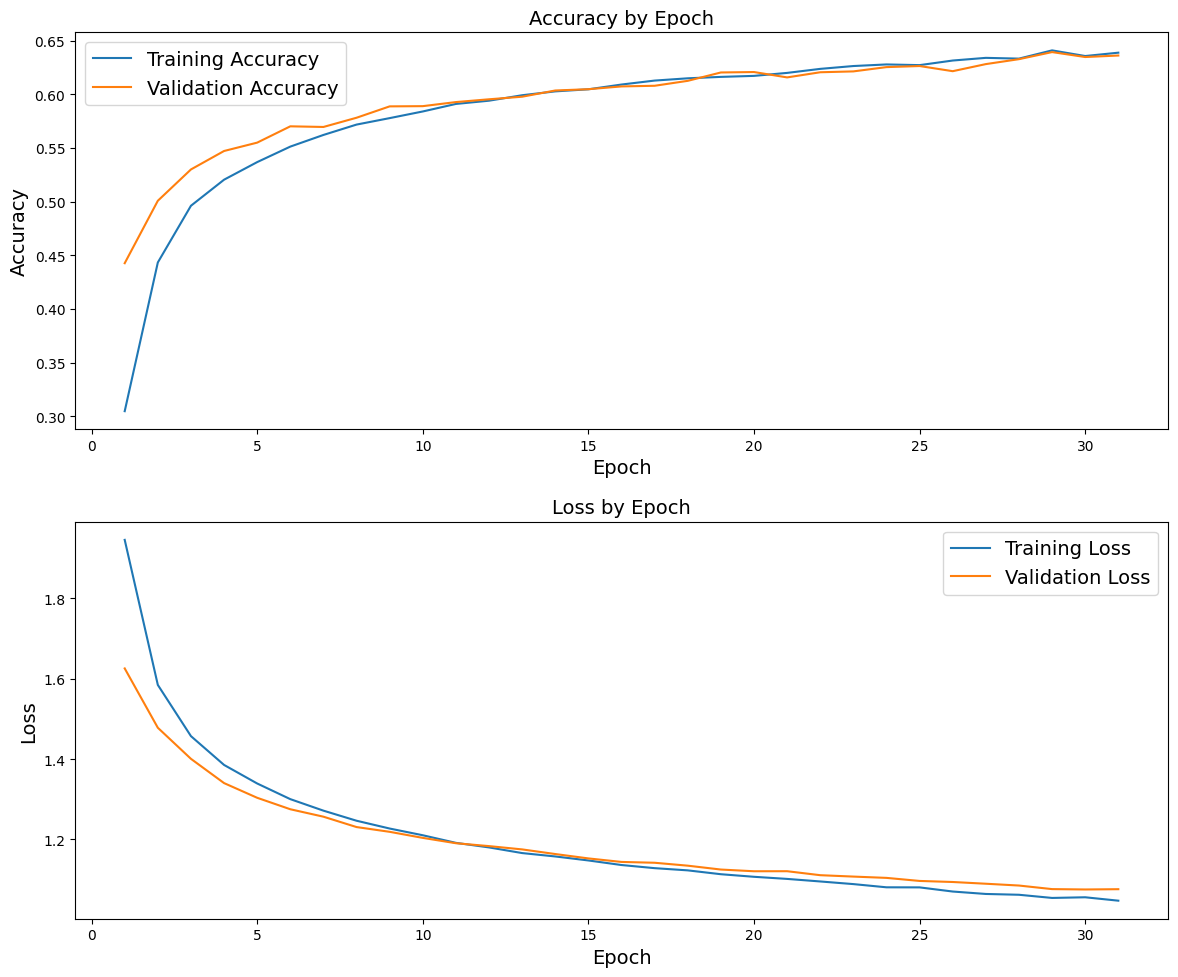

In [23]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(model_1_epochs, model_1_accuracy, label="Training Accuracy")
plt.plot(model_1_epochs, model_1_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(model_1_epochs, model_1_loss, label="Training Loss")
plt.plot(model_1_epochs, model_1_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()



In [24]:
y_pred_probs = model_1.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_test_model_1 = y_test.argmax(axis=1)              ## to make sure y pred and y test are the same shape

acc = accuracy_score(y_test_model_1, y_pred)
prec = precision_score(y_test_model_1, y_pred, average='weighted')
rec = recall_score(y_test_model_1, y_pred, average='weighted')
f1 = f1_score(y_test_model_1, y_pred, average='weighted')

print(f"model_1 Accuracy: {acc:.4f}")
print(f"model_1 Precision: {prec:.4f}")
print(f"model_1 Recall: {rec:.4f}")
print(f"model_1 F1 Score: {f1:.4f}")

report = classification_report(y_test_model_1, y_pred, target_names=class_names)
print(report)

296/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2026-02-18 13:18:43.382535: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
model_1 Accuracy: 0.6299
model_1 Precision: 0.6328
model_1 Recall: 0.6299
model_1 F1 Score: 0.6276
              precision    recall  f1-score   support

    airplane       0.64      0.71      0.68      1000
  automobile       0.74      0.73      0.73      1000
        bird       0.54      0.42      0.48      1000
         cat       0.44      0.54      0.48      1000
        deer       0.57      0.56      0.57      1000
         dog       0.60      0.44      0.51      1000
        frog       0.64      0.79      0.71      1000
       horse       0.72      0.66      0.69      1000
        ship       0.75      0.71      0.73      1000
       truck       0.69      0.72      0.71      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



# Model 2

## Architecture

In [25]:
model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(32,32,3)),
        tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(
        32,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                           # pooling layer

    tf.keras.layers.Conv2D(
        64,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(
        64,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                            # pooling layer

    tf.keras.layers.Conv2D(
        128,
        kernel_size=3,
        padding="valid",
        activation="relu",
        kernel_initializer="he_normal"),

    tf.keras.layers.MaxPool2D(),                            # pooling layer

    tf.keras.layers.Flatten(),                              # bridge to the dense layer

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [26]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,298 (1.10 MB)

 Trainable params: 288,298 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling

In [27]:
model_2_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [28]:
model_2.compile(
    loss="categorical_crossentropy",
    optimizer= model_2_optimizer,
    metrics=["accuracy"]
    )

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',                 # metric to monitor             
    patience=3,                         # stop if no improvement after 3 epochs
    restore_best_weights=True
)

## Fitting

In [30]:
model_2_history = model_2.fit(
    image_augmentor,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
681/704 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3267 - loss: 1.8154

2026-02-18 13:19:24.188025: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3297 - loss: 1.8079

2026-02-18 13:19:29.330265: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.4185 - loss: 1.5839 - val_accuracy: 0.5296 - val_loss: 1.3636
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5842 - loss: 1.1682 - val_accuracy: 0.6670 - val_loss: 0.9610
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6532 - loss: 0.9908 - val_accuracy: 0.7166 - val_loss: 0.8146
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6859 - loss: 0.8949 - val_accuracy: 0.7080 - val_loss: 0.8393
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7112 - loss: 0.8268 - val_accuracy: 0.7398 - val_loss: 0.7505
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7274 - loss: 0.7822 - val_accuracy: 0.7486 - val_loss: 0.7271
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7449 - loss: 0.7369 - val_accuracy: 0.7550 - val_loss: 0.7085
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7510 - loss: 0.7120 - val_

## Evaluating Model

In [31]:
model_2_accuracy = model_2_history.history["accuracy"]
model_2_accuracy_val = model_2_history.history["val_accuracy"]
model_2_loss = model_2_history.history["loss"]
model_2_loss_val = model_2_history.history["val_loss"]

model_2_epochs = range(1,len(model_2_accuracy)+1)

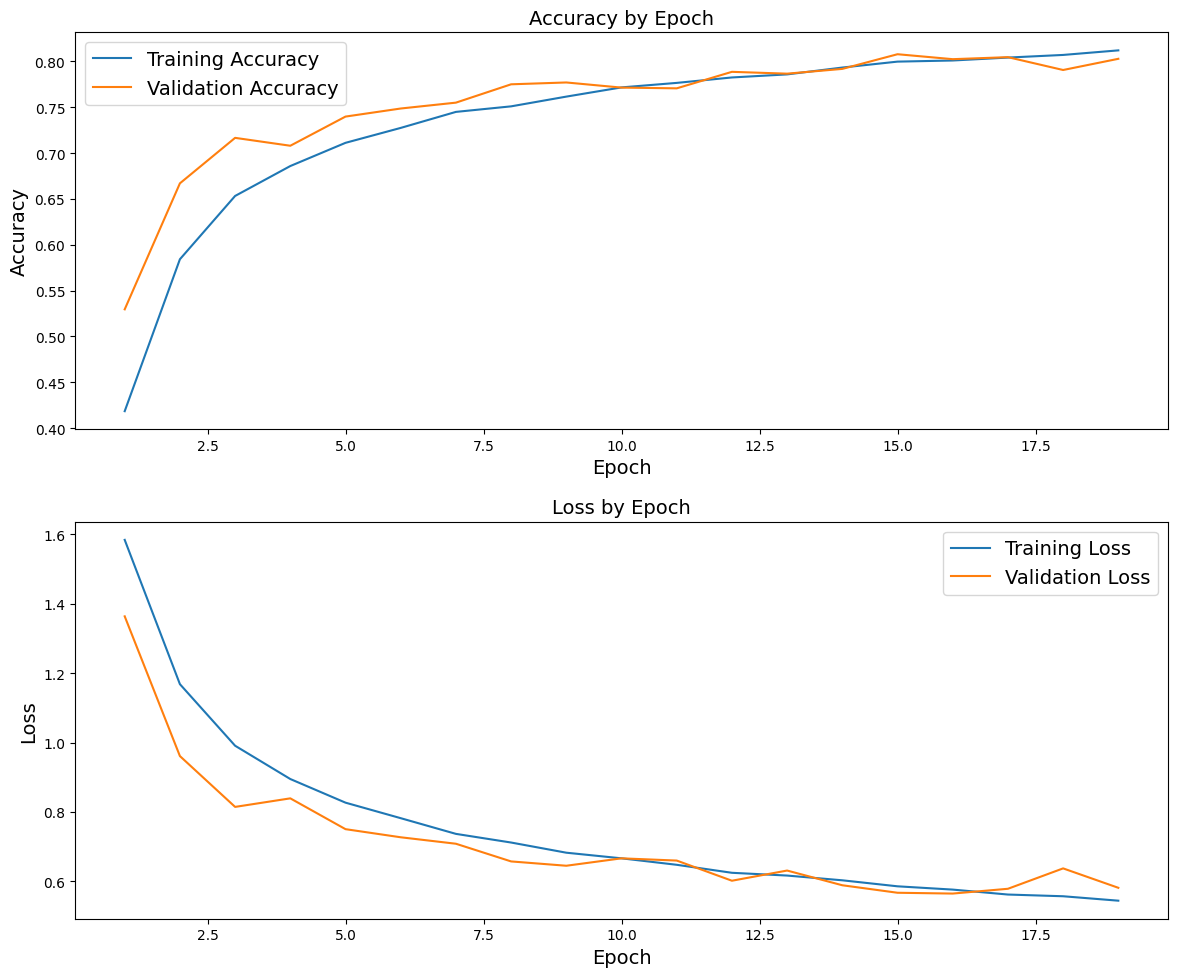

In [32]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(model_2_epochs, model_2_accuracy, label="Training Accuracy")
plt.plot(model_2_epochs, model_2_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(model_2_epochs, model_2_loss, label="Training Loss")
plt.plot(model_2_epochs, model_2_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
y_pred_probs = model_2.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_test_model_2 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_model_2, y_pred)
prec = precision_score(y_test_model_2, y_pred, average='weighted')
rec = recall_score(y_test_model_2, y_pred, average='weighted')
f1 = f1_score(y_test_model_2, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_model_2, y_pred, target_names=class_names)
print(f"\n{report}")

290/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2026-02-18 13:23:14.236692: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
model_2 Accuracy: 0.8080
model_2 Precision: 0.8123
model_2 Recall: 0.8080
model_2 F1 Score: 0.8080

              precision    recall  f1-score   support

    airplane       0.80      0.85      0.82      1000
  automobile       0.94      0.89      0.92      1000
        bird       0.80      0.67      0.73      1000
         cat       0.61      0.72      0.66      1000
        deer       0.84      0.70      0.77      1000
         dog       0.75      0.72      0.73      1000
        frog       0.82      0.85      0.84      1000
       horse       0.81      0.87      0.84      1000
        ship       0.90      0.88      0.89      1000
       truck       0.85      0.92      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



# --- Scaling for transfer models (64,64,3) --- 

*Mobile net has a stride problem, for images this small we need to reduce its stride but doing so essentiall requires a rewrite.*

updating image augmentor to rescale images to 64,64,3 - 96,96,3 may be better for alogtihms but for local running 64 is more reasonable.

In [15]:
X_train_scaled_64 = tf.image.resize(X_train, (64, 64), antialias=True)
X_valid_scaled_64 = tf.image.resize(X_valid, (64, 64), antialias=True)
X_test_scaled_64  = tf.image.resize(X_test, (64, 64), antialias=True)


I0000 00:00:1771430715.281681   44130 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11006 MB memory:  -> device: 0, name: AMD Radeon RX 6750 XT, pci bus id: 0000:2d:00.0
2026-02-18 16:05:16.052311: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2211840000 exceeds 10% of free system memory.


In [16]:
image_augmentor_scaled_64 = idg.flow(
    X_train_scaled_64,
    y_train,
    batch_size=64
)

# Transfer Learning Mobile Net v2  - Attempt 1  - All layers Frozen

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [111]:
base_model_1 = MobileNetV2(
    input_shape=(64, 64, 3),    # 32,32,3 is the lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "Max",            # has a meltdown if this is set to anything other than "None"
    weights="imagenet"
    )
base_model_1.trainable = False  # Freeze base so mobilenet v2 isn't being trained

/tmp/ipykernel_288373/1613259723.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_1 = MobileNetV2(


In [112]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [113]:
transfer_model_1 = models.Sequential([
    base_model_1,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [114]:
transfer_model_1_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_1.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_1_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',             # metric to monitor
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [115]:
transfer_model_1_history = transfer_model_1.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.5188 - loss: 1.3879 - val_accuracy: 0.6392 - val_loss: 1.0574
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.6103 - loss: 1.1361 - val_accuracy: 0.6496 - val_loss: 1.0130
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.6324 - loss: 1.0702 - val_accuracy: 0.6520 - val_loss: 0.9963
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.6460 - loss: 1.0346 - val_accuracy: 0.6664 - val_loss: 0.9664
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.6519 - loss: 1.0047 - val_accuracy: 0.6608 - val_loss: 0.9614
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.6615 - loss: 0.9785 - val_accuracy: 0.6734 - val_loss: 0.9549
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.6668 - loss: 0.9617 - val_accuracy: 0.6726 - val_loss: 0.9495
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.6731 - loss: 0

## Evaluating Model

In [116]:
transfer_model_1_accuracy = transfer_model_1_history.history["accuracy"]
transfer_model_1_accuracy_val = transfer_model_1_history.history["val_accuracy"]
transfer_model_1_loss = transfer_model_1_history.history["loss"]
transfer_model_1_loss_val = transfer_model_1_history.history["val_loss"]

transfer_model_1_history_epochs = range(1,len(transfer_model_1_accuracy)+1)

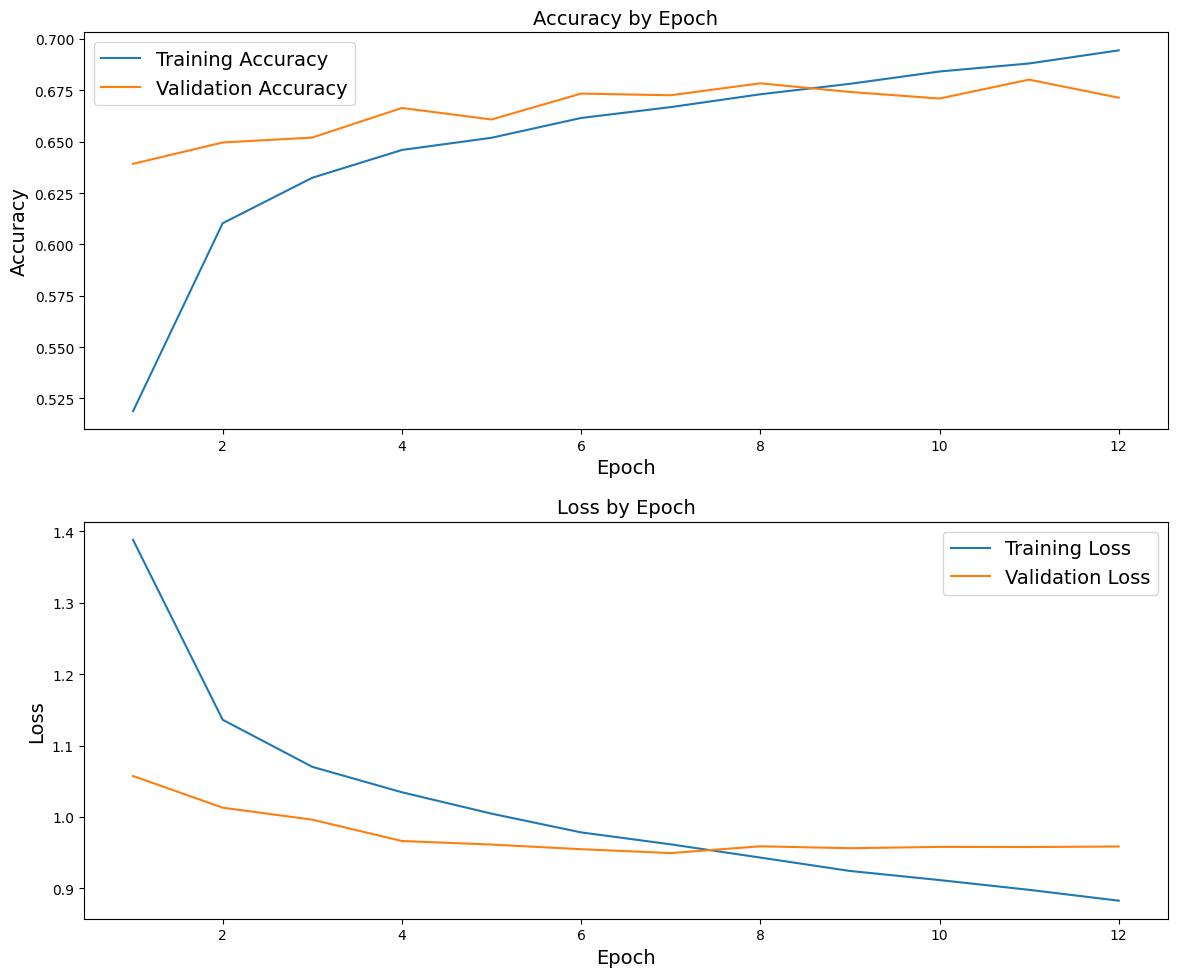

In [117]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_1_history_epochs, transfer_model_1_accuracy, label="Training Accuracy")
plt.plot(transfer_model_1_history_epochs, transfer_model_1_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_1_history_epochs, transfer_model_1_loss, label="Training Loss")
plt.plot(transfer_model_1_history_epochs, transfer_model_1_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [118]:
y_pred_probs = transfer_model_1.predict(X_test_scaled_64)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_1 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_1, y_pred)
prec = precision_score(y_test_transfer_model_1, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_1, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_1, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_1, y_pred, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step
model_2 Accuracy: 0.6771
model_2 Precision: 0.6772
model_2 Recall: 0.6771
model_2 F1 Score: 0.6759

              precision    recall  f1-score   support

    airplane       0.68      0.70      0.69      1000
  automobile       0.74      0.79      0.76      1000
        bird       0.62      0.54      0.58      1000
         cat       0.52      0.58      0.55      1000
        deer       0.61      0.59      0.60      1000
         dog       0.68      0.56      0.62      1000
        frog       0.70      0.74      0.72      1000
       horse       0.75      0.71      0.73      1000
        ship       0.73      0.78      0.75      1000
       truck       0.76      0.77      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



# Transfer Learning Mobile Net v2  - Attempt 2  - Unfreeze 40 of 155 layers

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [119]:
base_model_2 = MobileNetV2(
    input_shape=(64, 64, 3),    # lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "Max",
    weights= "imagenet",
    )

/tmp/ipykernel_288373/1932568423.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_2 = MobileNetV2(


In [120]:
len(base_model_2.layers)

154

In [121]:
for layer in base_model_2.layers[-40:]:
    layer.trainable = True


In [122]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [123]:
transfer_model_2 = models.Sequential([
    base_model_2,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [124]:
transfer_model_2_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_2.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_2_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [125]:
transfer_model_2_history = transfer_model_2.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 83ms/step - accuracy: 0.6832 - loss: 0.9940 - val_accuracy: 0.2236 - val_loss: 2.0287
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.7648 - loss: 0.7376 - val_accuracy: 0.2486 - val_loss: 4.6113
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.7815 - loss: 0.6823 - val_accuracy: 0.3228 - val_loss: 3.6565
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.7730 - loss: 0.6885 - val_accuracy: 0.4990 - val_loss: 1.5230
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.7964 - loss: 0.6258 - val_accuracy: 0.4954 - val_loss: 2.9054
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.7757 - loss: 0.6797 - val_accuracy: 0.5900 - val_loss: 2.1572
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.8137 - loss: 0.5652 - val_accuracy: 0.5998 - val_loss: 1.5377
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.7567 - loss: 0

## Evaluating Model

In [126]:
transfer_model_2_accuracy = transfer_model_2_history.history["accuracy"]
transfer_model_2_accuracy_val = transfer_model_2_history.history["val_accuracy"]
transfer_model_2_loss = transfer_model_2_history.history["loss"]
transfer_model_2_loss_val = transfer_model_2_history.history["val_loss"]

transfer_model_2_history_epochs = range(1,len(transfer_model_2_accuracy)+1)

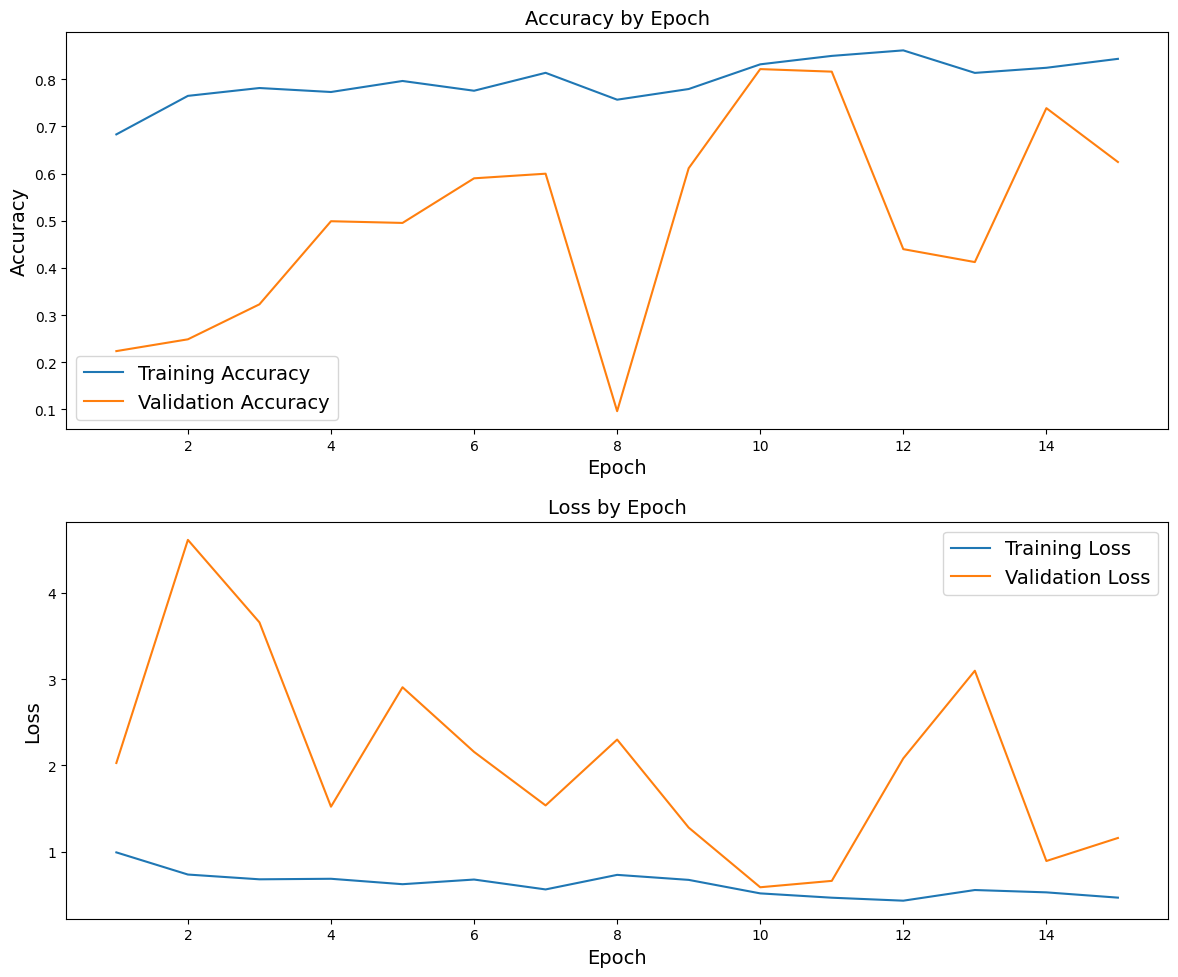

In [127]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_2_history_epochs, transfer_model_2_accuracy, label="Training Accuracy")
plt.plot(transfer_model_2_history_epochs, transfer_model_2_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_2_history_epochs, transfer_model_2_loss, label="Training Loss")
plt.plot(transfer_model_2_history_epochs, transfer_model_2_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [128]:
y_pred_probs = transfer_model_2.predict(X_test_scaled_64)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_2 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_2, y_pred)
prec = precision_score(y_test_transfer_model_2, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_2, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_2, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_2, y_pred, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step
model_2 Accuracy: 0.8139
model_2 Precision: 0.8209
model_2 Recall: 0.8139
model_2 F1 Score: 0.8099

              precision    recall  f1-score   support

    airplane       0.85      0.84      0.84      1000
  automobile       0.90      0.94      0.92      1000
        bird       0.72      0.78      0.75      1000
         cat       0.81      0.45      0.58      1000
        deer       0.77      0.84      0.80      1000
         dog       0.66      0.83      0.74      1000
        frog       0.81      0.88      0.84      1000
       horse       0.90      0.83      0.86      1000
        ship       0.95      0.82      0.88      1000
       truck       0.83      0.93      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



# Transfer Learning Mobile Net v2  - Attempt 3  - Unfreeze Fewer Layers - 20

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [129]:
base_model_3 = MobileNetV2(
    input_shape =(64, 64, 3),
    include_top =False,
    pooling = "Max",
    weights = "imagenet",
    )

/tmp/ipykernel_288373/415551669.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_3 = MobileNetV2(


In [130]:
for layer in base_model_3.layers[-20:]:
    layer.trainable = True

In [131]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [132]:
transfer_model_3 = models.Sequential([
    base_model_3,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [133]:
transfer_model_3_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_3.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_3_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',             # metric to monitor
    patience=5,                     # stop if no improvement after 3 epochs
    restore_best_weights=True
)

In [134]:
transfer_model_3_history = transfer_model_3.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.6780 - loss: 1.0016 - val_accuracy: 0.3788 - val_loss: 3.3532
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.7697 - loss: 0.7125 - val_accuracy: 0.3638 - val_loss: 3.3403
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.7614 - loss: 0.7388 - val_accuracy: 0.4064 - val_loss: 2.5462
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.7982 - loss: 0.6198 - val_accuracy: 0.5722 - val_loss: 1.5805
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.7892 - loss: 0.6481 - val_accuracy: 0.3134 - val_loss: 4.6964
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.8146 - loss: 0.5812 - val_accuracy: 0.7482 - val_loss: 1.1119
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.8218 - loss: 0.5497 - val_accuracy: 0.7436 - val_loss: 1.0394
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.8010 - loss: 0

## Evaluating Model

In [135]:
transfer_model_3_accuracy = transfer_model_3_history.history["accuracy"]
transfer_model_3_accuracy_val = transfer_model_3_history.history["val_accuracy"]
transfer_model_3_loss = transfer_model_3_history.history["loss"]
transfer_model_3_loss_val = transfer_model_3_history.history["val_loss"]

transfer_model_3_history_epochs = range(1,len(transfer_model_3_accuracy)+1)

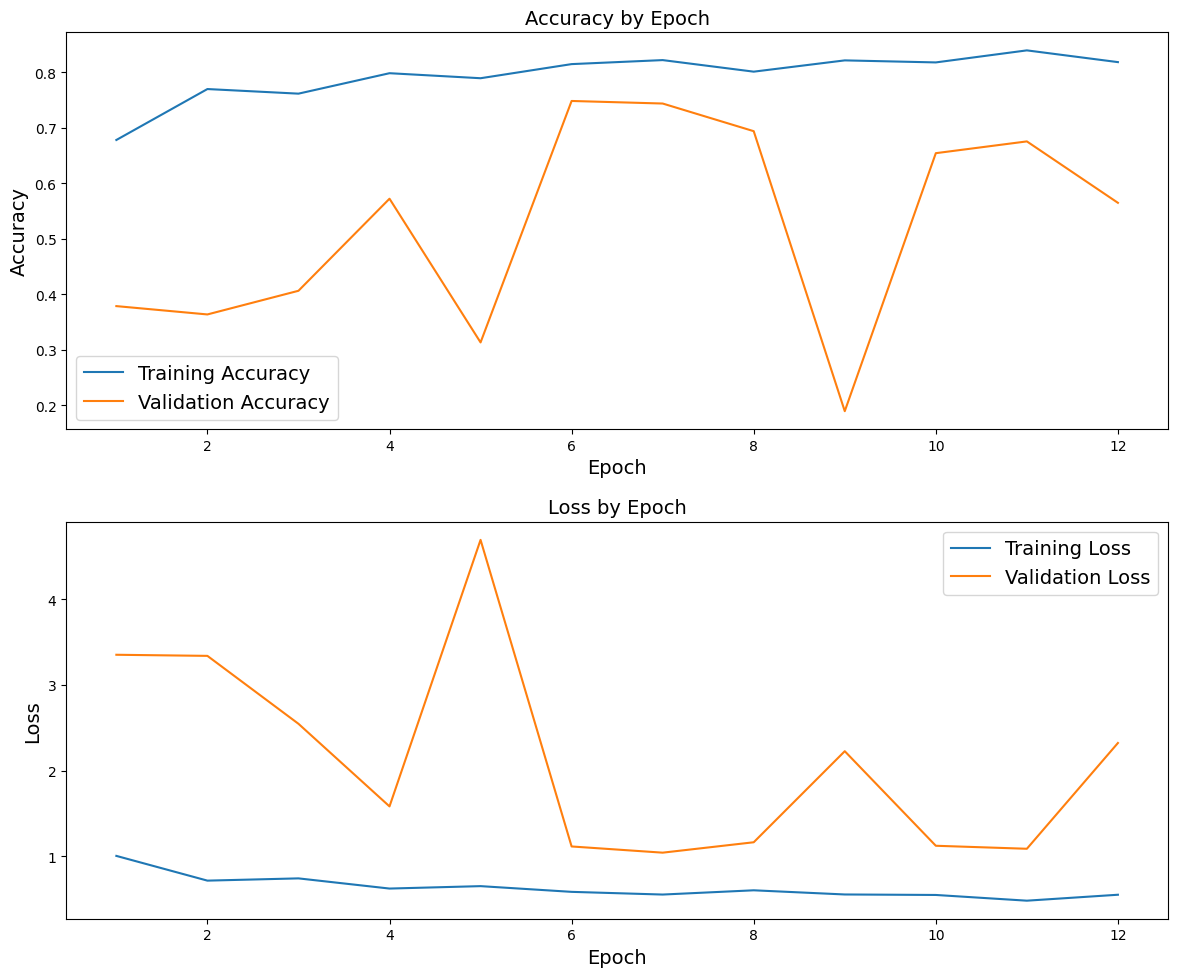

In [136]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_3_history_epochs, transfer_model_3_accuracy, label="Training Accuracy")
plt.plot(transfer_model_3_history_epochs, transfer_model_3_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_3_history_epochs, transfer_model_3_loss, label="Training Loss")
plt.plot(transfer_model_3_history_epochs, transfer_model_3_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [137]:
y_pred_probs = transfer_model_3.predict(X_test_scaled_64)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_3 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_3, y_pred)
prec = precision_score(y_test_transfer_model_3, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_3, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_3, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_3, y_pred, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
model_2 Accuracy: 0.7416
model_2 Precision: 0.7607
model_2 Recall: 0.7416
model_2 F1 Score: 0.7353

              precision    recall  f1-score   support

    airplane       0.82      0.70      0.76      1000
  automobile       0.80      0.94      0.87      1000
        bird       0.73      0.57      0.64      1000
         cat       0.79      0.39      0.52      1000
        deer       0.77      0.71      0.74      1000
         dog       0.56      0.84      0.68      1000
        frog       0.87      0.72      0.79      1000
       horse       0.89      0.74      0.81      1000
        ship       0.67      0.91      0.78      1000
       truck       0.70      0.89      0.79      1000

    accuracy                           0.74     10000
   macro avg       0.76      0.74      0.74     10000
weighted avg       0.76      0.74      0.74     10000



# Transfer Learning ResNet50V2  - Attempt 1 - All layers Frozen

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [138]:
base_model_4 = ResNet50V2(
    input_shape =(64, 64, 3),
    include_top =False,
    pooling = "Max",
    weights = "imagenet"
    )
base_model_4.trainable = False  # Don't freeze base so EfficientNetB0 can be trained as we have no weights just the structure

In [139]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [140]:
transfer_model_4 = models.Sequential([
    base_model_4,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [ ]:
transfer_model_4_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_4.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_4_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.01             # metric to monitor
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [142]:
transfer_model_4_history = transfer_model_4.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.5019 - loss: 1.4569 - val_accuracy: 0.6108 - val_loss: 1.1129
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.5748 - loss: 1.2261 - val_accuracy: 0.6296 - val_loss: 1.0524
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.5965 - loss: 1.1587 - val_accuracy: 0.6438 - val_loss: 1.0251
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.6046 - loss: 1.1323 - val_accuracy: 0.6410 - val_loss: 1.0107
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.6178 - loss: 1.1045 - val_accuracy: 0.6534 - val_loss: 1.0001
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.6224 - loss: 1.0815 - val_accuracy: 0.6520 - val_loss: 0.9975
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.6265 - loss: 1.0746 - val_accuracy: 0.6564 - val_loss: 0.9848
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.6302 - loss: 1

KeyboardInterrupt: 

## Evaluating Model

In [ ]:
transfer_model_4_accuracy = transfer_model_4_history.history["accuracy"]
transfer_model_4_accuracy_val = transfer_model_4_history.history["val_accuracy"]
transfer_model_4_loss = transfer_model_4_history.history["loss"]
transfer_model_4_loss_val = transfer_model_4_history.history["val_loss"]

transfer_model_4_history_epochs = range(1,len(transfer_model_4_accuracy)+1)

NameError: name 'transfer_model_4_history' is not defined

In [ ]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_4_history_epochs, transfer_model_4_accuracy, label="Training Accuracy")
plt.plot(transfer_model_4_history_epochs, transfer_model_4_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_4_history_epochs, transfer_model_4_loss, label="Training Loss")
plt.plot(transfer_model_4_history_epochs, transfer_model_4_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
y_pred_probs = transfer_model_4.predict(X_test_scaled_64)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_4 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_4, y_pred)
prec = precision_score(y_test_transfer_model_4, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_4, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_4, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_4, y_pred, target_names=class_names)
print(f"\n{report}")

# Transfer Learning ResNet50V2  - Attempt 2 - Unfreeze Fewer Layers - 40

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [17]:
base_model_5 = ResNet50V2(
    input_shape =(64, 64, 3),
    include_top =False,
    pooling = "Max",
    weights = "imagenet"
    )


In [18]:
len(base_model_5.layers)

190

In [19]:
for layer in base_model_5.layers[-40:]:
    layer.trainable = True


In [ ]:
# output_double = tf.keras.Sequential([
#     tf.keras.layers.Dense(
#         128,
#         activation="relu",
#         kernel_initializer="he_normal"),
#     tf.keras.layers.Dense(
#         128,
#         activation="relu",
#         kernel_initializer="he_normal"),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(
#         10,
#         activation="softmax")
# ])

In [20]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [21]:
transfer_model_5 = models.Sequential([
    base_model_5,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [22]:
transfer_model_5_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_5.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_5_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',             # metric to monitor
    min_delta = 0.01,  
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [24]:
transfer_model_5_history = transfer_model_5.fit(
    image_augmentor_scaled_64,
    epochs=100,
    validation_data=(X_valid_scaled_64, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 60s 85ms/step - accuracy: 0.7588 - loss: 0.7465 - val_accuracy: 0.5622 - val_loss: 1.5797
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.7933 - loss: 0.6414 - val_accuracy: 0.7772 - val_loss: 0.6706
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.8149 - loss: 0.5744 - val_accuracy: 0.6920 - val_loss: 0.9227
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.8284 - loss: 0.5279 - val_accuracy: 0.7780 - val_loss: 0.6626
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.8432 - loss: 0.4758 - val_accuracy: 0.7610 - val_loss: 0.7773
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.8511 - loss: 0.4555 - val_accuracy: 0.6946 - val_loss: 1.2112
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.8644 - loss: 0.4180 - val_accuracy: 0.6878 - val_loss: 1.0236


## Evaluating Model

In [25]:
transfer_model_5_accuracy = transfer_model_5_history.history["accuracy"]
transfer_model_5_accuracy_val = transfer_model_5_history.history["val_accuracy"]
transfer_model_5_loss = transfer_model_5_history.history["loss"]
transfer_model_5_loss_val = transfer_model_5_history.history["val_loss"]

transfer_model_5_history_epochs = range(1,len(transfer_model_5_accuracy)+1)

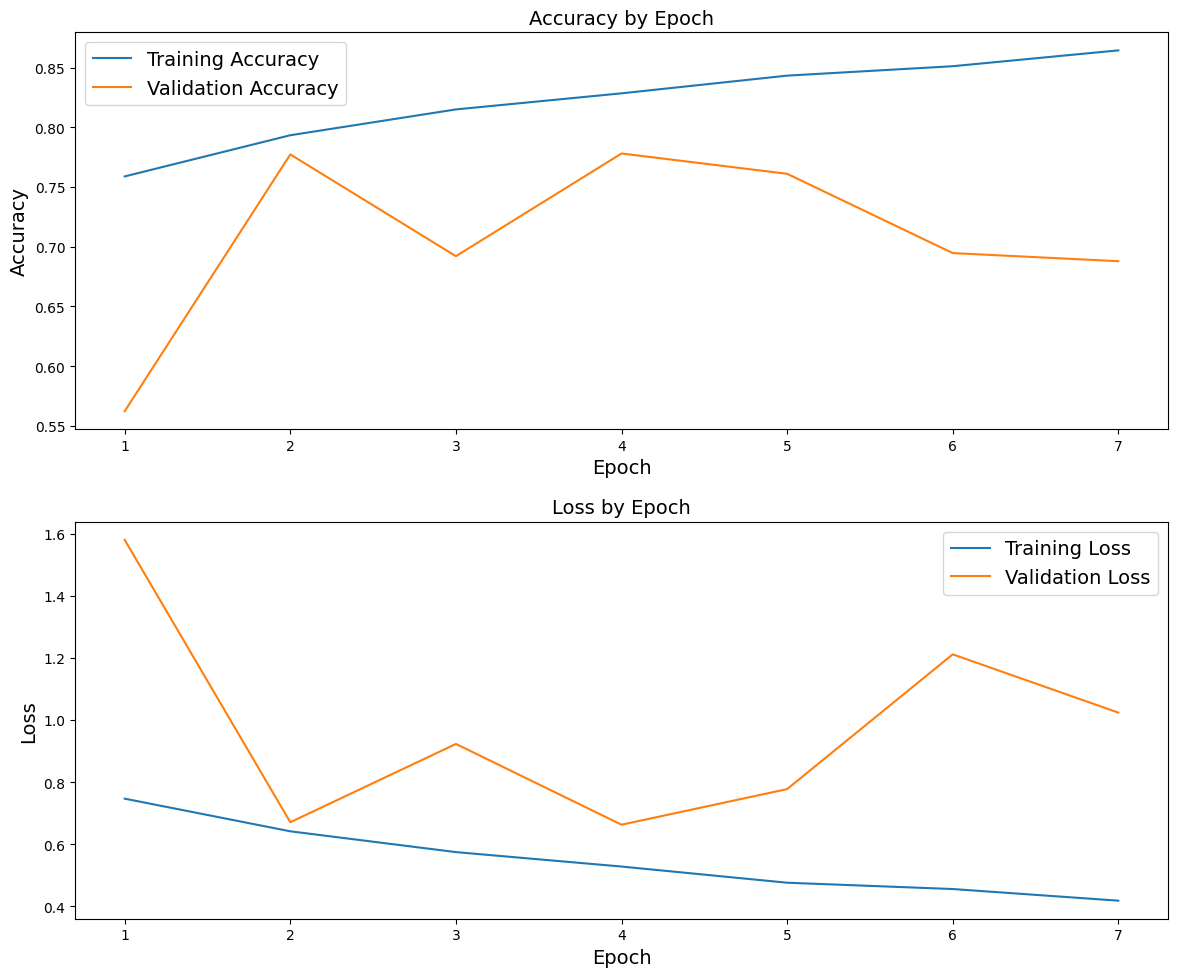

In [26]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_5_history_epochs, transfer_model_5_accuracy, label="Training Accuracy")
plt.plot(transfer_model_5_history_epochs, transfer_model_5_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_5_history_epochs, transfer_model_5_loss, label="Training Loss")
plt.plot(transfer_model_5_history_epochs, transfer_model_5_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
y_pred_probs = transfer_model_5.predict(X_test_scaled_64)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_5 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_5, y_pred)
prec = precision_score(y_test_transfer_model_5, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_5, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_5, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_5, y_pred, target_names=class_names)
print(f"\n{report}")

310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

2026-02-18 15:21:24.781423: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step
model_2 Accuracy: 0.7694
model_2 Precision: 0.7757
model_2 Recall: 0.7694
model_2 F1 Score: 0.7668

              precision    recall  f1-score   support

    airplane       0.64      0.86      0.74      1000
  automobile       0.86      0.93      0.89      1000
        bird       0.79      0.65      0.71      1000
         cat       0.60      0.61      0.61      1000
        deer       0.83      0.69      0.76      1000
         dog       0.78      0.56      0.65      1000
        frog       0.76      0.88      0.82      1000
       horse       0.86      0.77      0.81      1000
        ship       0.82      0.84      0.83      1000
       truck       0.81      0.89      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



# --- Scaling for transfer models (96,96,3) ---

*Mobile net has a stride problem, for images this small we need to reduce its stride but doing so essentiall requires a rewrite.*

updating image augmentor to rescale images to 64,64,3 - 96,96,3 may be better for alogtihms but for local running 64 is more reasonable.

In [17]:
X_train_scaled_96 = tf.image.resize(X_train, (96, 96), antialias=True)
X_valid_scaled_96 = tf.image.resize(X_valid, (96, 96), antialias=True)
X_test_scaled_96  = tf.image.resize(X_test, (96, 96), antialias=True)


2026-02-18 16:05:21.811143: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 4976640000 exceeds 10% of free system memory.
2026-02-18 16:05:21.811178: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1658880000 exceeds 10% of free system memory.


In [18]:
image_augmentor_scaled_96 = idg.flow(
    X_train_scaled_96,
    y_train,
    batch_size=64
)

# Transfer Learning Mobile Net v2  - Attempt 4  - Unfreeze 40 - 96 96 3 version

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [45]:
base_model_6 = MobileNetV2(
    input_shape=(96, 96, 3),    # lower limit of mobilenetv2 and it struggles badly
    include_top=False,
    pooling= "Max",
    weights= "imagenet",
    )

In [46]:
len(base_model_6.layers)

154

In [47]:
for layer in base_model_6.layers[-40:]:
    layer.trainable = True


In [48]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [49]:
transfer_model_6 = models.Sequential([
    base_model_6,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [50]:
transfer_model_6_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_6.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_6_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [51]:
transfer_model_6_history = transfer_model_6.fit(
    image_augmentor_scaled_96,
    epochs=100,
    validation_data=(X_valid_scaled_96, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 134s 144ms/step - accuracy: 0.7866 - loss: 0.6947 - val_accuracy: 0.1730 - val_loss: 9.1408
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 114ms/step - accuracy: 0.8539 - loss: 0.4679 - val_accuracy: 0.4360 - val_loss: 3.9149
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - accuracy: 0.8768 - loss: 0.3949 - val_accuracy: 0.3198 - val_loss: 5.9240
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 111ms/step - accuracy: 0.8908 - loss: 0.3504 - val_accuracy: 0.5644 - val_loss: 2.9432
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 110ms/step - accuracy: 0.8958 - loss: 0.3297 - val_accuracy: 0.3676 - val_loss: 9.4445
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 110ms/step - accuracy: 0.9038 - loss: 0.3031 - val_accuracy: 0.7544 - val_loss: 1.1615
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 110ms/step - accuracy: 0.9101 - loss: 0.2830 - val_accuracy: 0.7610 - val_loss: 1.2099
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 110ms/step - accuracy: 0.9141 

## Evaluating Model

In [52]:
transfer_model_6_accuracy = transfer_model_6_history.history["accuracy"]
transfer_model_6_accuracy_val = transfer_model_6_history.history["val_accuracy"]
transfer_model_6_loss = transfer_model_6_history.history["loss"]
transfer_model_6_loss_val = transfer_model_6_history.history["val_loss"]

transfer_model_6_history_epochs = range(1,len(transfer_model_6_accuracy)+1)

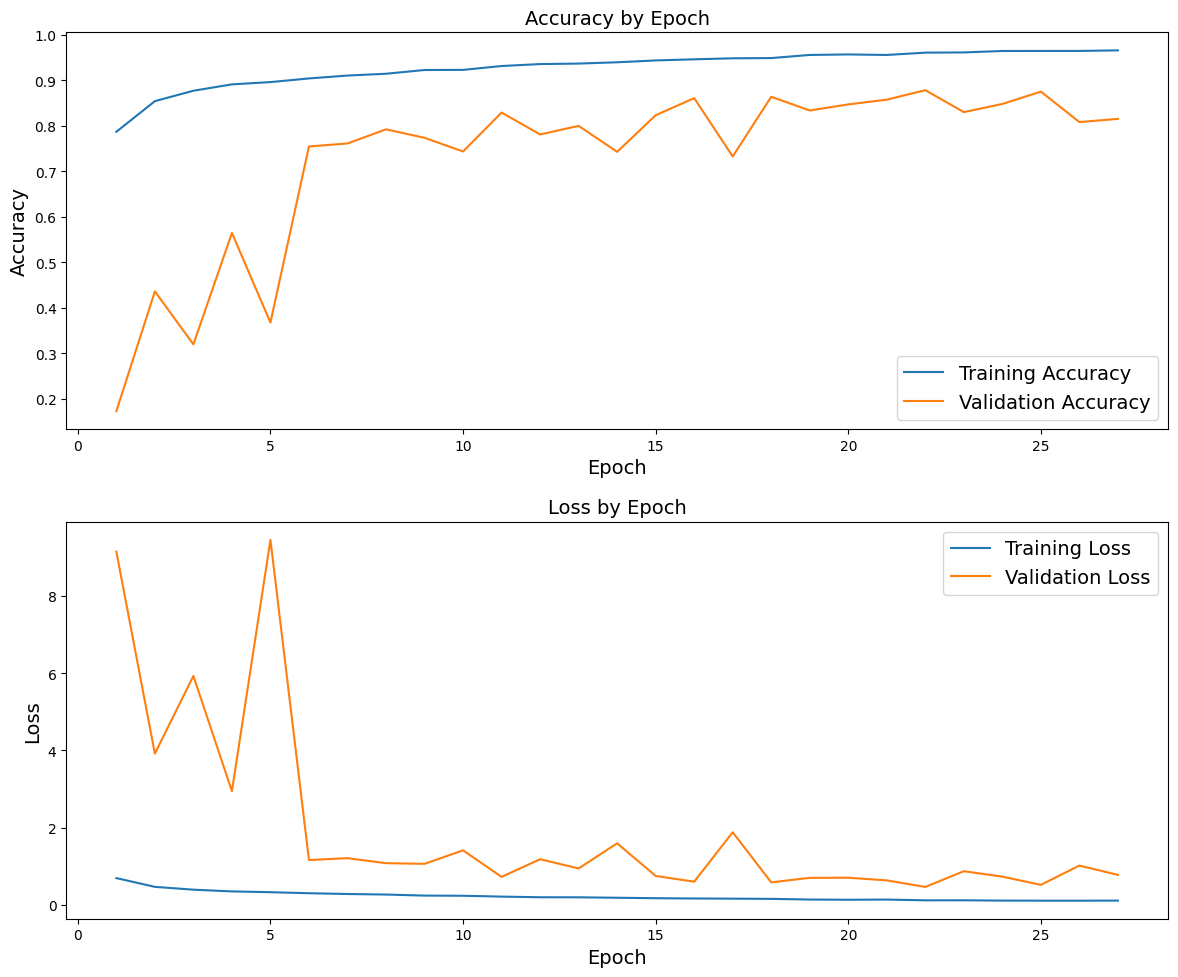

In [53]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_6_history_epochs, transfer_model_6_accuracy, label="Training Accuracy")
plt.plot(transfer_model_6_history_epochs, transfer_model_6_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_6_history_epochs, transfer_model_6_loss, label="Training Loss")
plt.plot(transfer_model_6_history_epochs, transfer_model_6_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [54]:
y_pred_probs = transfer_model_6.predict(X_test_scaled_96)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_6 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_6, y_pred)
prec = precision_score(y_test_transfer_model_6, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_6, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_6, y_pred, average='weighted')

print(f"model_6 Accuracy: {acc:.4f}")
print(f"model_6 Precision: {prec:.4f}")
print(f"model_6 Recall: {rec:.4f}")
print(f"model_6 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_6, y_pred, target_names=class_names)
print(f"\n{report}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step
model_6 Accuracy: 0.8771
model_6 Precision: 0.8826
model_6 Recall: 0.8771
model_6 F1 Score: 0.8762

              precision    recall  f1-score   support

    airplane       0.89      0.91      0.90      1000
  automobile       0.87      0.99      0.93      1000
        bird       0.87      0.90      0.88      1000
         cat       0.88      0.67      0.76      1000
        deer       0.91      0.83      0.87      1000
         dog       0.76      0.83      0.80      1000
        frog       0.98      0.88      0.93      1000
       horse       0.78      0.97      0.86      1000
        ship       0.94      0.90      0.92      1000
       truck       0.95      0.89      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



# Transfer Learning ResNet50V2  - Attempt 3 - Unfreeze Fewer Layers - 40 - scaled 96,96,3

## Import

importing MobileNetV2, and then put it on the "bottom" of the model so it interacts with the model first, before our model.

In [19]:
base_model_7 = ResNet50V2(
    input_shape =(96, 96, 3),
    include_top =False,
    pooling = "Max",
    weights = "imagenet"
    )


In [20]:
len(base_model_7.layers)

190

In [21]:
for layer in base_model_7.layers[-40:]:
    layer.trainable = True


In [22]:
output = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(
        10,
        activation="softmax")
])

In [23]:
transfer_model_7 = models.Sequential([
    base_model_7,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector, mobilenetv2 won't put out a raw image
    output
])

In [24]:
transfer_model_7_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

transfer_model_7.compile(
    loss="categorical_crossentropy",
    optimizer= transfer_model_7_optimizer,
    metrics=["accuracy"]
    )

early_stopping = EarlyStopping(
    monitor='val_loss',             # metric to monitor
    min_delta = 0.01,  
    patience=5,                     # stop if no improvement after 5 epochs
    restore_best_weights=True
)

In [25]:
transfer_model_7_history = transfer_model_7.fit(
    image_augmentor_scaled_96,
    epochs=100,
    validation_data=(X_valid_scaled_96, y_valid),
    callbacks=[early_stopping]
    )

Epoch 1/100


2026-02-18 16:05:42.107767: I external/local_xla/xla/service/service.cc:163] XLA service 0x7feae8009070 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
2026-02-18 16:05:42.107780: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): AMD Radeon RX 6750 XT, AMDGPU ISA version: gfx1030
2026-02-18 16:05:42.517414: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1771430754.728799   44324 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


482/704 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.5135 - loss: 1.4616

2026-02-18 16:06:48.933935: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5529 - loss: 1.3489

2026-02-18 16:07:41.616839: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


704/704 ━━━━━━━━━━━━━━━━━━━━ 135s 155ms/step - accuracy: 0.6544 - loss: 1.0581 - val_accuracy: 0.6082 - val_loss: 1.3603
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.7751 - loss: 0.6958 - val_accuracy: 0.4282 - val_loss: 1.9464
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 113ms/step - accuracy: 0.8122 - loss: 0.5848 - val_accuracy: 0.7430 - val_loss: 0.8169
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.8336 - loss: 0.5060 - val_accuracy: 0.6632 - val_loss: 1.1946
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.8496 - loss: 0.4641 - val_accuracy: 0.7830 - val_loss: 0.6440
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.8657 - loss: 0.4124 - val_accuracy: 0.7998 - val_loss: 0.6223
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.8742 - loss: 0.3878 - val_accuracy: 0.7592 - val_loss: 0.7294
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.8836 - loss: 0.35

## Evaluating Model

In [26]:
transfer_model_7_accuracy = transfer_model_7_history.history["accuracy"]
transfer_model_7_accuracy_val = transfer_model_7_history.history["val_accuracy"]
transfer_model_7_loss = transfer_model_7_history.history["loss"]
transfer_model_7_loss_val = transfer_model_7_history.history["val_loss"]

transfer_model_7_history_epochs = range(1,len(transfer_model_7_accuracy)+1)

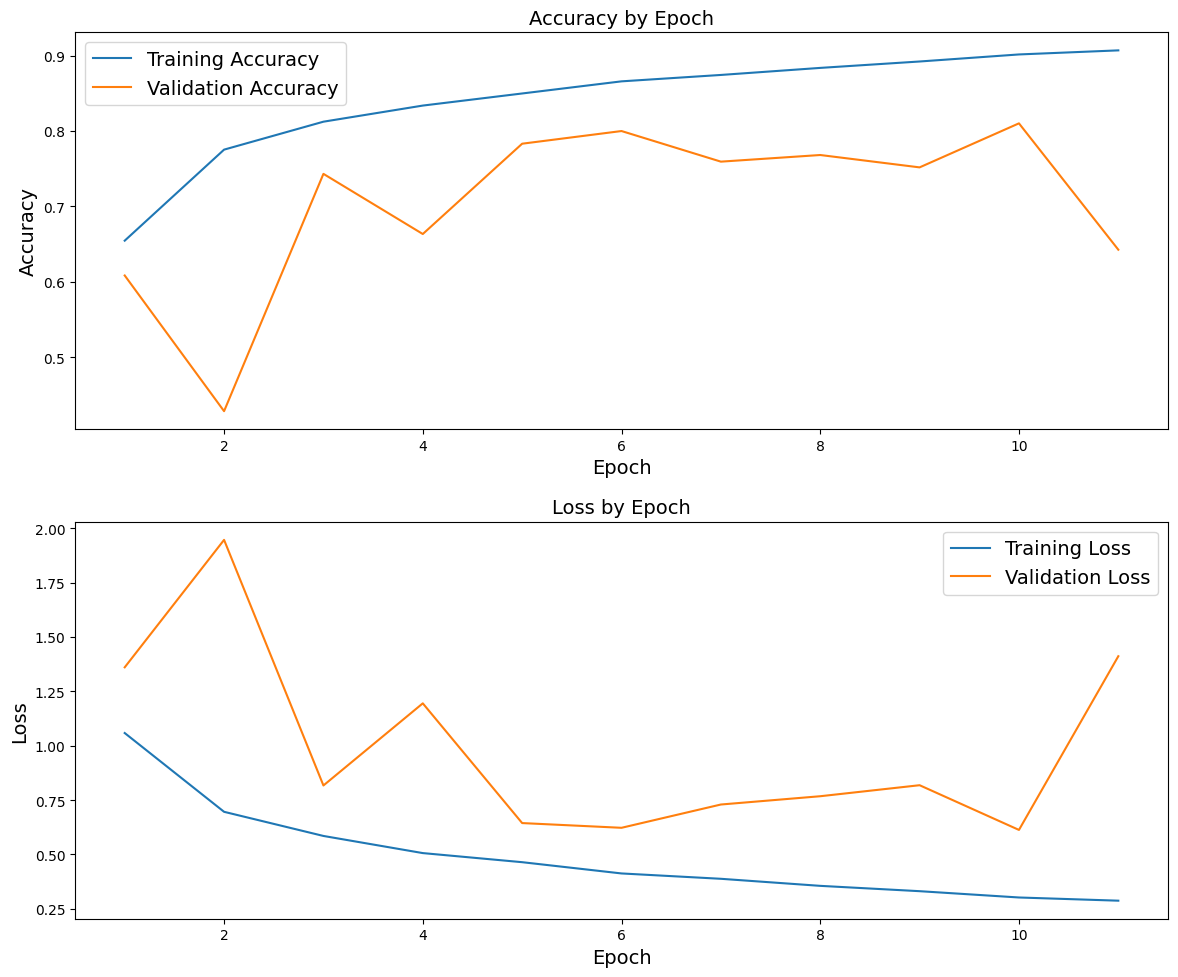

In [27]:
plt.figure(figsize=(12, 10))

#####

plt.subplot(2, 1, 1)
plt.plot(transfer_model_7_history_epochs, transfer_model_7_accuracy, label="Training Accuracy")
plt.plot(transfer_model_7_history_epochs, transfer_model_7_accuracy_val, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#####

plt.subplot(2, 1, 2)
plt.plot(transfer_model_7_history_epochs, transfer_model_7_loss, label="Training Loss")
plt.plot(transfer_model_7_history_epochs, transfer_model_7_loss_val, label="Validation Loss")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
y_pred_probs = transfer_model_7.predict(X_test_scaled_96)
y_pred = y_pred_probs.argmax(axis=1)
y_test_transfer_model_7 = y_test.argmax(axis=1) 

acc = accuracy_score(y_test_transfer_model_7, y_pred)
prec = precision_score(y_test_transfer_model_7, y_pred, average='weighted')
rec = recall_score(y_test_transfer_model_7, y_pred, average='weighted')
f1 = f1_score(y_test_transfer_model_7, y_pred, average='weighted')

print(f"model_2 Accuracy: {acc:.4f}")
print(f"model_2 Precision: {prec:.4f}")
print(f"model_2 Recall: {rec:.4f}")
print(f"model_2 F1 Score: {f1:.4f}")

report = classification_report(y_test_transfer_model_7, y_pred, target_names=class_names)
print(f"\n{report}")

311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

2026-02-18 16:21:06.481989: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step
model_2 Accuracy: 0.7999
model_2 Precision: 0.8259
model_2 Recall: 0.7999
model_2 F1 Score: 0.8012

              precision    recall  f1-score   support

    airplane       0.89      0.74      0.81      1000
  automobile       0.75      0.98      0.85      1000
        bird       0.92      0.60      0.73      1000
         cat       0.56      0.83      0.67      1000
        deer       0.79      0.87      0.83      1000
         dog       0.82      0.66      0.74      1000
        frog       0.75      0.92      0.83      1000
       horse       0.93      0.80      0.86      1000
        ship       0.92      0.83      0.88      1000
       truck       0.92      0.76      0.83      1000

    accuracy                           0.80     10000
   macro avg       0.83      0.80      0.80     10000
weighted avg       0.83      0.80      0.80     10000

